# Observando a linha de 21cm

## Instruções

### Instalação:

- Siga as instruções em https://github.com/lbarosi/GNURadioBlocks e instale o bloco FITS_SINK
- Clone este repositório

### Uso

#### Aquisição de Dados

- Ative o ambiente conda: `conda activate gnuradio`
- Execute o gnuradio-companion a partir do terminal
- Abra o flow `minihorn_flow.grc` na pasta gnuradio
- Edite a variável `prefix` para o caminho completo onde você quiser gravar os arquivos, incluindo um prefixo para todos eles. (ex: `../data/raw/GNURADIO/minicorneta_ALT45`)
- Execute o flow por quanto tempo desejar.

#### Análise de dados

- Caso necessário ajuste a variável `obs.backend.controller.local_folder` para apontar para a pasta onde os arquivos foram salvos.
- Ajuste a variável `RTLSDRGNU.name` com o prefixo que você escolheu para os arquivos.
- Caso necessário, edite o tempo da  observação. Por padrão ele considera todas as medidas do dia corrente a partir da meia-noite como sendo parte do mesmo conjunto.
- Pode ser preciso testar valores diferentes da variável `window` para filtrar RFI.

## Inicialização

In [1]:
# Mostra todos os resultados da célula, não apenas o último
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
InteractiveShell.ast_node_interactivity = "all"
import logging
import os
import sys
import astropy.units as u
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append(os.path.abspath(os.path.join(os.path.split(os.getcwd())[0])))
sys.path.append(os.path.abspath(os.path.join(os.path.split(os.getcwd())[0], "radiotelescope")))
sys.path.append(os.path.abspath(os.path.join(os.path.split(os.getcwd())[0], "radiotelescope/GNURadio")))
from radiotelescope.observations.observations import Observations as Obs
from radiotelescope.instruments import RTLSDRGNU
from radiotelescope.observations.observations import MAD_filter, RFI_filter, plot_mosaic
logger = logging.getLogger("radiotelescope")
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)

Para observações conecte o dongle na porta USB local.


In [9]:
def calibrate_baseline(data, window=100, threshold=10, cold=True):
    """ Efetua subtração de baseline nos dados e mascara canais com RFI intensa."""
    data = pd.DataFrame(data.values.byteswap().newbyteorder(), columns = obs.data.columns, index=obs.data.index).copy()
    if cold:
        df_cold = obs.backend._get_filenames(extension="fit", mode="01").filenames
        df_cold_data = obs.backend.load_measurement(filenames=df_cold)
        baseline, mask = MAD_filter(df_cold_data.median(axis=0).copy(), window=window, threshold=threshold, imputation="median")
    else:
        baseline, mask = MAD_filter(data.median(axis=0).copy(), window=window, threshold=threshold, imputation="median")
    data = data.subtract(baseline[0], axis=1)
    freqs_filtered = mask[mask==1.0].dropna().reset_index()["index"]
    data.loc[:, freqs_filtered] = np.nan 
    return data

## Analisando Dados

In [10]:
# fuso = RTLSDRGNU.instrument.timezone
# begin = fuso.localize(pd.to_datetime("2022-10-28 00:00:00"))

In [14]:
# Edite o tempo inicial se necessário.
# fuso = RTLSDRGNU.instrument.timezone
# t_start = fuso.localize(pd.to_datetime("2022-10-28 00:00:00"))
# obs = Obs(t_start=t_start, duration=pd.Timedelta(24, unit="h"))
obs = Obs(duration=pd.Timedelta(24, unit="h")).initialize()
obs.backend = RTLSDRGNU
# Edite este nome com o prefixo que você usou no gnuradio.
RTLSDRGNU.name = "minicorneta"
# Se necessário, altere esta variável para apontar para os seus dados.
obs.backend.controller.local_folder
# Carrega todas as observações feitas no período determinado com o prefixo indicado.
obs.load_observation(extension="fit");

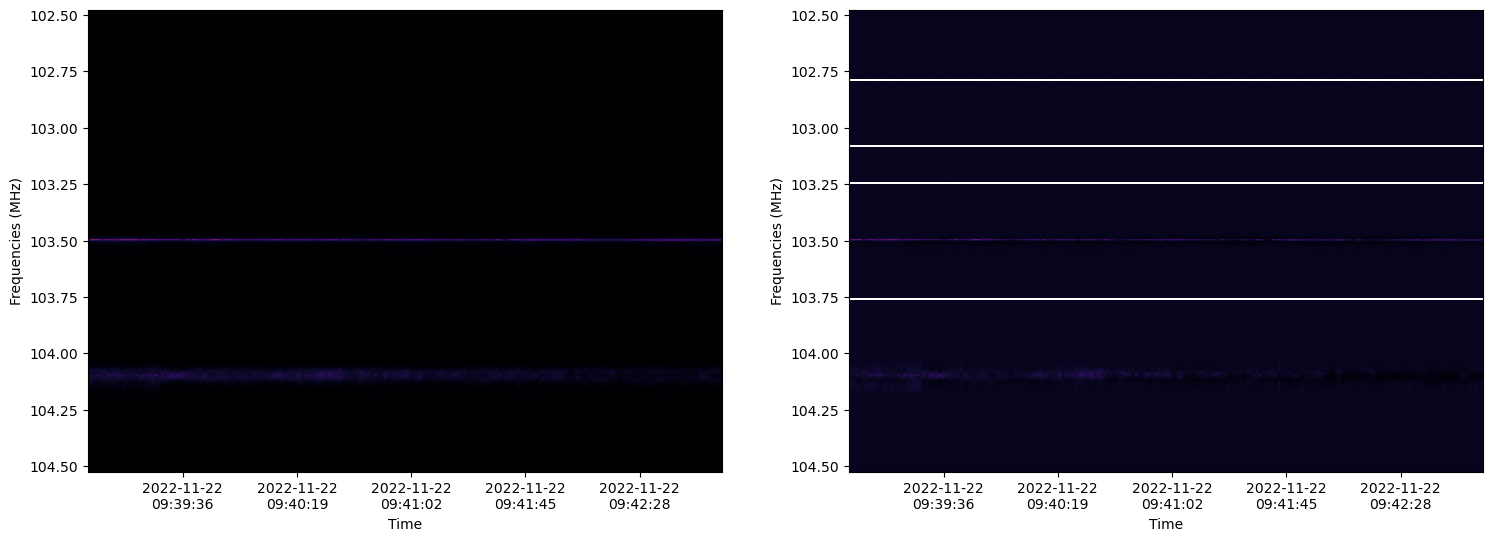

In [23]:
# Experimente com a variável window, ela deve ser maior do que 1 vezes a largura da interferência.
# O valor da variável window representa número de canais de frequência. Cada um deles corresponde a 
# (largura de banda) / N_FFT
df_clean = calibrate_baseline(obs.data.copy(), window=100, threshold=20, cold=True)
# Dados brutos e com subtração de baseline lado a lado.
plot_mosaic([obs.data, df_clean]);

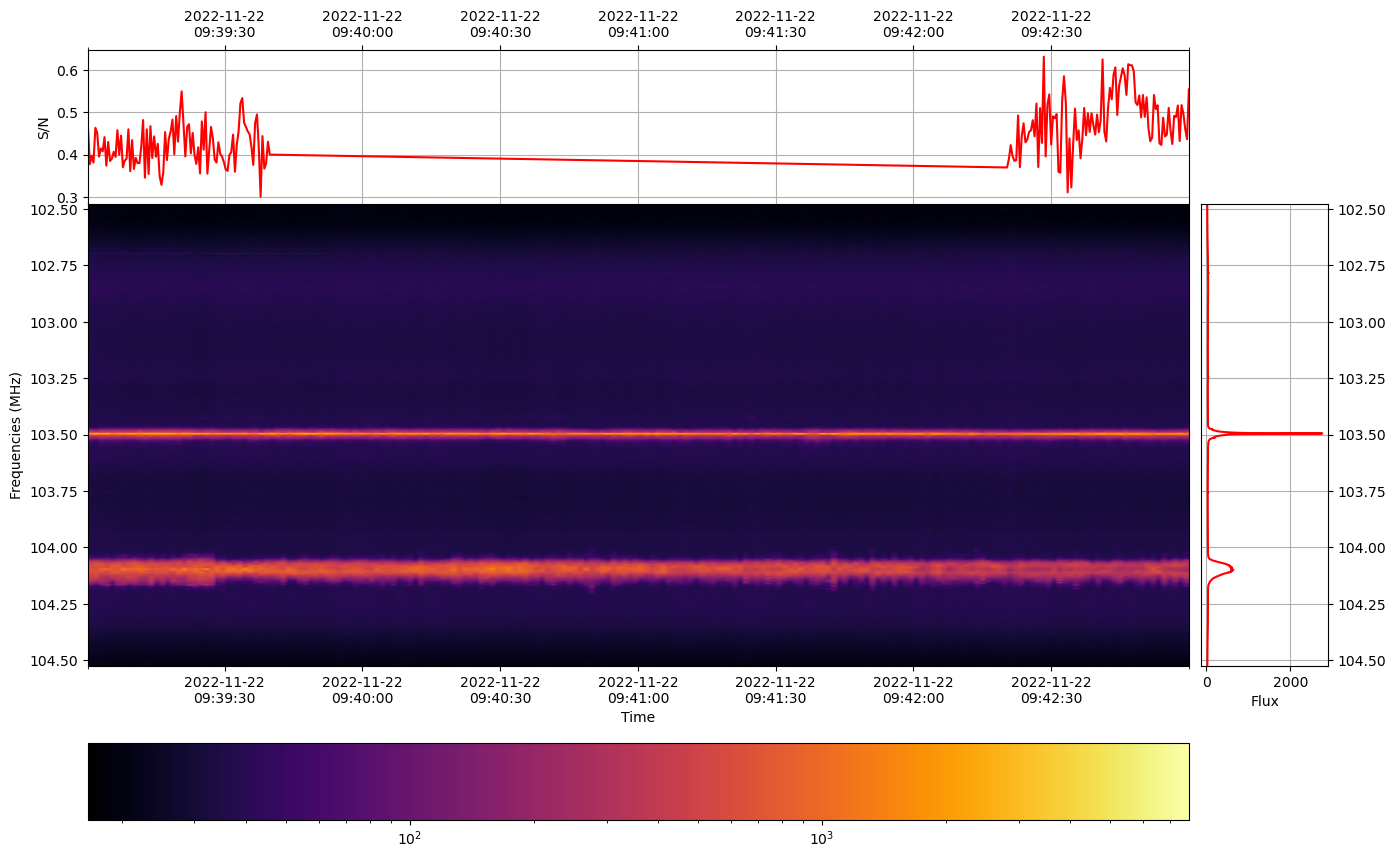

In [19]:
obs.plot_waterfall(obs.data, norm=LogNorm());